In [4]:
tags_src = 'anime, cute female vocals, j-pop'
tags_tgt = 'anime, male vocals, j-pop'

In [1]:
import os
from transformers import UMT5EncoderModel, AutoTokenizer

text_encoder_checkpoint_path = os.path.join('/home/mabondarenko_4/ACE_CHECKPOINTS/models--ACE-Step--ACE-Step-v1-3.5B/snapshots/82cd0d7b6322bd28cd4e830fe675ddb6180ce36c', "umt5-base")
text_tokenizer = AutoTokenizer.from_pretrained(
            text_encoder_checkpoint_path
        )

/home/mabondarenko_4/.conda/envs/music_p2p/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def tokenize_tags(tags, tokenizer):
    input_ids = tokenizer(
            tags,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=256,
    )['input_ids'].tolist()
    return [[tokenizer.decode(idx) for idx in input_id] for input_id in input_ids]



In [5]:
tokenize_tags([tags_src, tags_tgt], text_tokenizer)

[['anime', ',', 'cute', 'female', 'vocal', 's', ',', 'j', '-', 'pop', '</s>'],
 ['anime', ',', 'male', 'vocal', 's', ',', 'j', '-', 'pop', '</s>', '<pad>']]

In [ ]:
import torch
from typing import List

def is_special_token(token: str):
    return token.startswith('<') and token.endswith('>')

def get_tags_replacement_mapper_(src_tokens: List[str], tgt_tokens: List[str]):
    M = torch.zeros(len(src_tokens), len(tgt_tokens))
    src_tag_toks = []
    tgt_tag_toks = []
    edit_mask = torch.zeros(len(tgt_tokens))

    src_l = 0   
    tgt_l = 0
    while True:
        while src_l < len(src_tokens) \
                and not is_special_token(src_tokens[src_l]) \
                and src_tokens[src_l] != ',':
            src_tag_toks.append(src_tokens[src_l])
            src_l += 1

        while tgt_l < len(tgt_tokens) \
                and not is_special_token(tgt_tokens[tgt_l]) \
                and tgt_tokens[tgt_l] != ',':
            tgt_tag_toks.append(tgt_tokens[tgt_l])
            tgt_l += 1

        if src_tag_toks != tgt_tag_toks:
            M[src_l-len(src_tag_toks):src_l,tgt_l-len(tgt_tag_toks):tgt_l] = 1 / len(tgt_tag_toks)
            edit_mask[tgt_l-len(tgt_tag_toks):tgt_l] = 1
        else:
            k = len(src_tag_toks)
            M[src_l-len(src_tag_toks):src_l,tgt_l-len(tgt_tag_toks):tgt_l] = torch.eye(k, k)

        src_tag_toks.clear()
        tgt_tag_toks.clear()

        if src_l < len(src_tokens) and src_tokens[src_l] == ',':
            M[src_l, tgt_l] = 1

        src_l += 1
        tgt_l += 1

        if src_l >= len(src_tokens) or is_special_token(src_tokens[src_l]):
            break

    return M, edit_mask

def get_tags_replacement_mapper(prompts: List[str], tokenizer):
    src_comma_count = prompts[0].count(',')
    for i in range(1, len(prompts)):
        tgt_i_comma_count = prompts[i].count(',')
        assert src_comma_count == tgt_i_comma_count, f"Src tags amount must be equal to tgt {i} tags amount"

    tokens = tokenize_tags(prompts, tokenizer)
    Ms = []
    edit_masks = []
    for i in range(1, len(tokens)):
        M, edit_mask = get_tags_replacement_mapper_(tokens[0], tokens[i])
        Ms.append(M)
        edit_masks.append(edit_mask)

    return torch.stack(Ms, dim=0), torch.stack(edit_masks, dim=0)


In [17]:
get_tags_replacement_mapper([tags_src, tags_tgt], text_tokenizer)[1]

tensor([[0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.]])

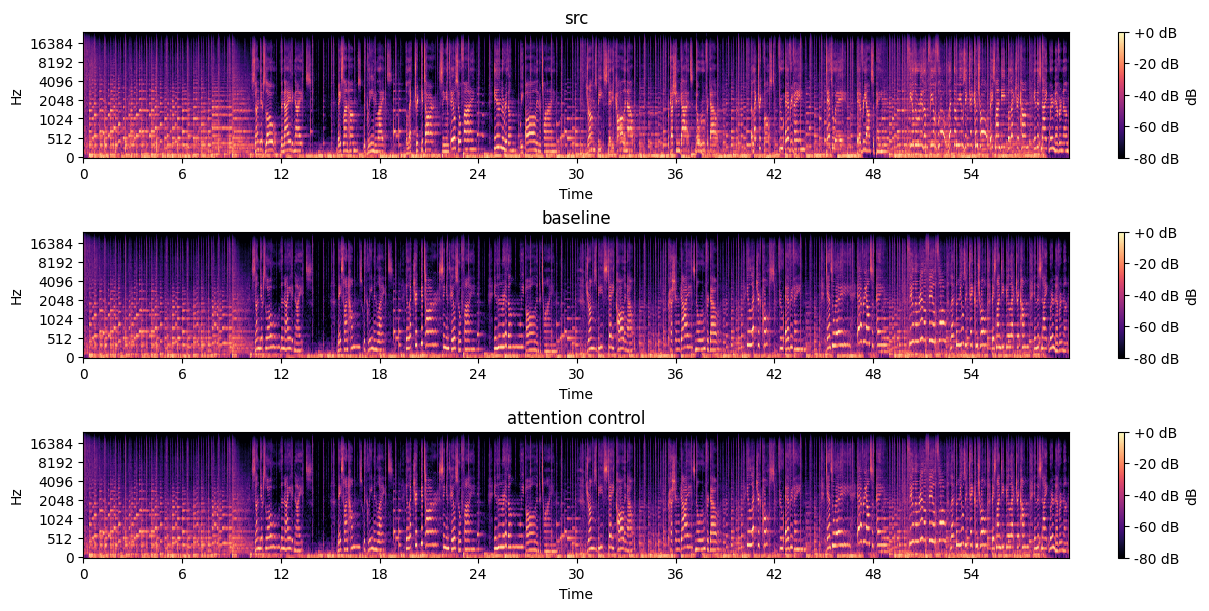

In [1]:
# --- CONFIG: укажите пути к аудио ---
src_path = "/home/mabondarenko_4/music_p2p/outputs_tags/full/cuba/output_20250901011512_0.wav"
attn_ctrl_path = "/home/mabondarenko_4/music_p2p/outputs_tags/full/cuba/output_20250901011513_2.wav"
baseline_path = "/home/mabondarenko_4/music_p2p/outputs_tags/full/cuba/output_20250901011513_2.wav"

# --- Параметры мел-спектрограммы (при желании поменяйте) ---
SR = None          # None => сохранять исходную частоту дискретизации; или задайте число, напр. 22050
N_FFT = 2048
HOP = 512
N_MELS = 128
FMIN = 0
FMAX = None        # None => sr/2

# --- Код ---
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

def load_audio(path, sr=SR):
    y, sr = librosa.load(path, sr=sr, mono=True)
    return y, sr

def mel_db(y, sr, n_fft=N_FFT, hop_length=HOP, n_mels=N_MELS, fmin=FMIN, fmax=FMAX):
    S = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=n_fft, hop_length=hop_length,
        n_mels=n_mels, fmin=fmin, fmax=fmax
    )
    return librosa.power_to_db(S, ref=np.max)

def plot_mel(ax, S_db, sr, hop_length=HOP, title=""):
    img = librosa.display.specshow(
        S_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', ax=ax
    )
    ax.set_title(title)
    cbar = plt.colorbar(img, ax=ax, format="%+2.0f dB")
    cbar.set_label("dB")

src_y, src_sr = load_audio(src_path, sr=SR)
base_y, base_sr = load_audio(baseline_path, sr=SR)
attn_y, attn_sr = load_audio(attn_ctrl_path, sr=SR)

src_S = mel_db(src_y, src_sr)
base_S = mel_db(base_y, base_sr)
attn_S = mel_db(attn_y, attn_sr)

fig, axes = plt.subplots(3, 1, figsize=(12, 6), constrained_layout=True)
plot_mel(axes[0], src_S,  src_sr, title="src")
plot_mel(axes[1], base_S, base_sr, title="baseline")
plot_mel(axes[2], attn_S, attn_sr, title="attention control")
plt.show()


In [14]:
from numpy.linalg import norm

In [15]:
norm(src_S - base_S)

np.float32(7481.0513)

In [16]:
norm(src_S - attn_S)

np.float32(9619.451)